In [1]:
import numpy as np
import pandas as pd
import pickle as pk
from matplotlib import pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
%matplotlib inline
mpl.rc('font',size=21,**{'family':'sans-serif','sans-serif':['Arial']})

In [2]:
wd = '/Volumes/eSSD0/Papers/GRL_G1RF/data/'
compsets = ['F1850CN','piClim-abrupt-4xCO2','piClim-abrupt-SOLr','piClim-G1']

tau = [0.,0.3,1.3,3.6,9.4,23.,60.,380.]
ctp = [1000,800,680,560,440,310,180,50]

isccp = {}
cl = {}
for i in range(len(compsets)):  
    isccp[compsets[i]] = np.nanmean(pk.load(open(wd+'interpolated/F_'+compsets[i]+'_diag_grid_int.pi','rb'))['isccp'],axis=0)
    cl[compsets[i]] = pk.load(open(wd+'interpolated/F_'+compsets[i]+'_diag_grid_int.pi','rb'))['cloud_int']

merge = {}
merge['cl'] = cl
merge['isccp'] = isccp

delta = {}
delta['x4'] = merge['isccp']['piClim-abrupt-4xCO2']-merge['isccp']['F1850CN']
delta['sol'] = merge['isccp']['piClim-abrupt-SOLr']-merge['isccp']['F1850CN']
delta['G1'] = merge['isccp']['piClim-G1']-merge['isccp']['F1850CN']
delta['G1L'] = delta['sol']+delta['x4']
delta['resid'] = delta['G1']-delta['G1L']

In [3]:
lat = np.linspace(-90,90,46)
lon = np.linspace(0,355,72)

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat[None,None,:,None],(7,7,1,72))

dgm = {}
gam = {}
for sim in delta.keys():
    dgm[sim] = np.average(delta[sim][:,:,:,:],weights=coslat[:,:,:,:],axis=(2,3))
    gam[sim] = np.nansum(dgm[sim],axis=(0,1))

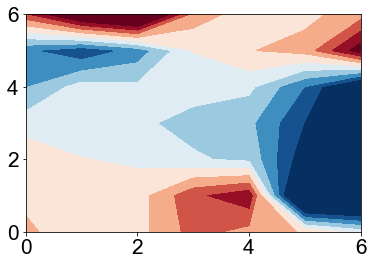

In [4]:
hist_spread = plt.contourf(dgm['x4'],np.arange(-0.4,0.41,0.1),cmap=plt.cm.RdBu_r,extend='both')
g1_spread = plt.contourf(dgm['x4'],np.arange(-0.1,0.11,0.025),cmap=plt.cm.RdBu_r,extend='both')

In [5]:
trop1 = np.linspace(300,100,23)
trop2 = np.linspace(100,300,23)
trop = np.concatenate((trop1,trop2))
trop_full = np.tile(trop[None,:],(17,1))

cmip_plevs = np.asarray([10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000])
plevs = np.tile(cmip_plevs[:,None],(1,46))

sol = {}
x4 = {}
g1 = {}
g1l = {}
resid = {}

sol['cl'] = np.nanmean(merge['cl']['piClim-abrupt-SOLr']-merge['cl']['F1850CN'],axis=(0,3))
x4['cl'] = np.nanmean(merge['cl']['piClim-abrupt-4xCO2']-merge['cl']['F1850CN'],axis=(0,3))
g1['cl'] = np.nanmean(merge['cl']['piClim-G1']-merge['cl']['F1850CN'],axis=(0,3))
g1l['cl'] = sol['cl']+x4['cl']
resid['cl'] = g1['cl']-g1l['cl']

In [11]:
lat[7:39]

array([-62., -58., -54., -50., -46., -42., -38., -34., -30., -26., -22.,
       -18., -14., -10.,  -6.,  -2.,   2.,   6.,  10.,  14.,  18.,  22.,
        26.,  30.,  34.,  38.,  42.,  46.,  50.,  54.,  58.,  62.])

/var/folders/r8/scfjvfsn7xs6hsgzf7hxgp140000gn/T/ipykernel_3158/3202391997.py:10: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(hist_spread,drawedges=True,label='%')
/var/folders/r8/scfjvfsn7xs6hsgzf7hxgp140000gn/T/ipykernel_3158/3202391997.py:19: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(g1_spread,drawedges=True,label='%')


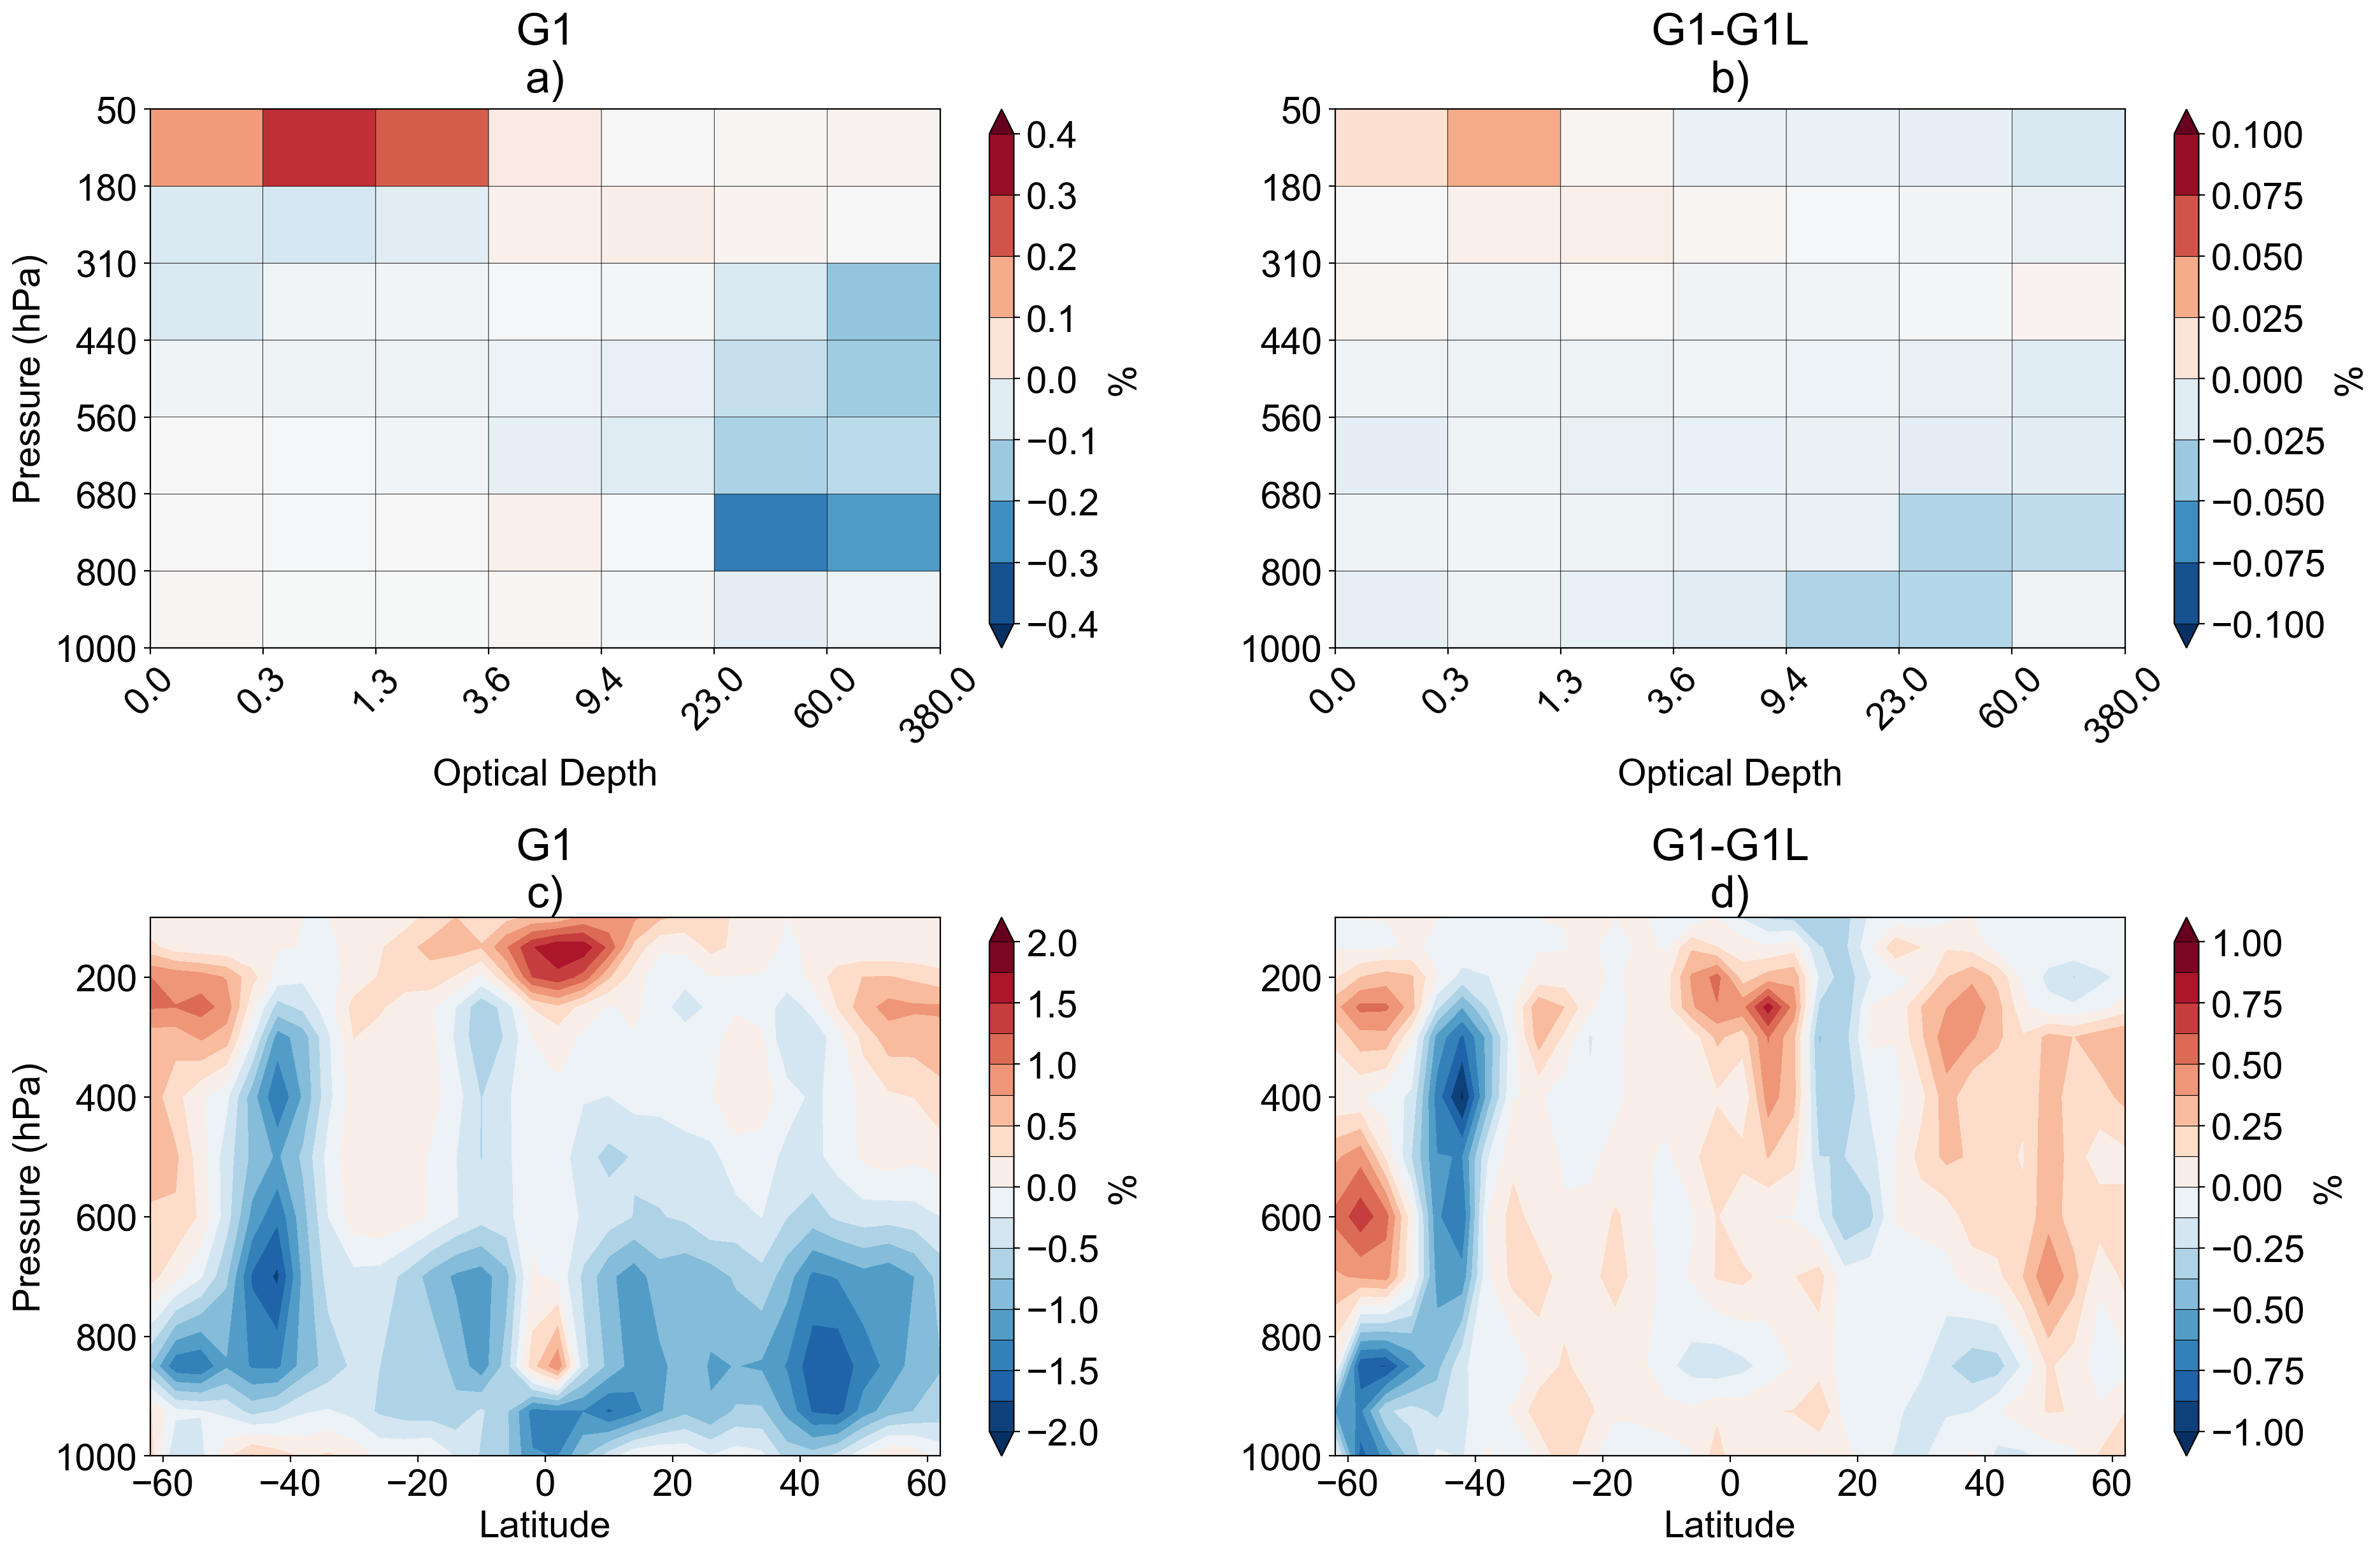

In [15]:
plt.figure(figsize=(22,14),dpi=200)

plt.subplot(221)
plt.title('G1\na)',pad=10)
hist_dat = plt.pcolor(dgm['G1'],cmap=plt.cm.RdBu_r,vmin=-0.4,vmax=0.41,edgecolors='k')
plt.xticks(np.arange(8), tau,rotation=45)
plt.yticks(np.arange(8), ctp)
plt.xlabel('Optical Depth')
plt.ylabel('Pressure (hPa)')
cb = plt.colorbar(hist_spread,drawedges=True,label='%')

plt.subplot(222)
plt.title('G1-G1L\nb)',pad=10)
hist_dat = plt.pcolor(dgm['resid'],cmap=plt.cm.RdBu_r,vmin=-0.1,vmax=0.11,edgecolors='k')
plt.xticks(np.arange(8), tau,rotation=45)
plt.yticks(np.arange(8), ctp)
plt.xlabel('Optical Depth')
#plt.ylabel('Cloud Top Pressure (hPa)')
cb = plt.colorbar(g1_spread,drawedges=True,label='%')

#CLOUDS
plt.subplot(223)
plt.title('G1\nc)')
cont3 = plt.contourf(lat[7:39],cmip_plevs[5:],g1['cl'][5:,7:39]*100,np.arange(-2,2.1,0.25),cmap=plt.cm.RdBu_r,extend='both')
plt.gca().invert_yaxis()
plt.colorbar(cont3,drawedges='True',label='%')
plt.xticks(ticks=[-60,-40,-20,0,20,40,60])
plt.xlabel('Latitude')
plt.ylabel('Pressure (hPa)')

plt.subplot(224)
plt.title('G1-G1L\nd)')
cont4 = plt.contourf(lat[7:39],cmip_plevs[5:],resid['cl'][5:,7:39]*100,np.arange(-1,1.1,0.125),cmap=plt.cm.RdBu_r,extend='both')
plt.gca().invert_yaxis()
plt.colorbar(cont4,drawedges='True',label='%')
plt.xticks(ticks=[-60,-40,-20,0,20,40,60])
plt.xlabel('Latitude')
plt.subplots_adjust(wspace=0.2,hspace=0.5)

plt.savefig('CL_ISCCP_ZM.png',bbox_inches='tight')